# Week 1: Feature Detection & Matching

This section implements the core feature extraction and matching pipeline needed for later 3D reconstruction steps.  
The tasks completed in Week 1 include:

- Loading and displaying the input dataset images  
- Detecting keypoints using **SIFT**  
- Computing descriptors for each detected keypoint  
- Matching descriptors between image pairs using **k-NN matching**  
- Applying **Lowe’s ratio test** to filter high-quality matches  
- Visualizing keypoints and matched feature correspondences  
- Preparing a reusable feature-matching function for Week 2 and beyond  

The output of this section includes visualizations of SIFT keypoints, matched features between two selected images, and a modular pipeline for extracting and matching features across the dataset.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

DATA_DIR = 'data'
IMAGE_FILENAMES = [f"{i}.jpeg" for i in range(1, 24)]

def load_images(filenames):
    images = {}
    for name in filenames:
        path = os.path.join(DATA_DIR, name)
        img = cv2.imread(path)
        if img is not None:
            images[name] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            print(f"Warning: Could not load {path}")
    return images

all_images = load_images(IMAGE_FILENAMES)
print(f"Successfully loaded {len(all_images)} images.")

Successfully loaded 23 images.


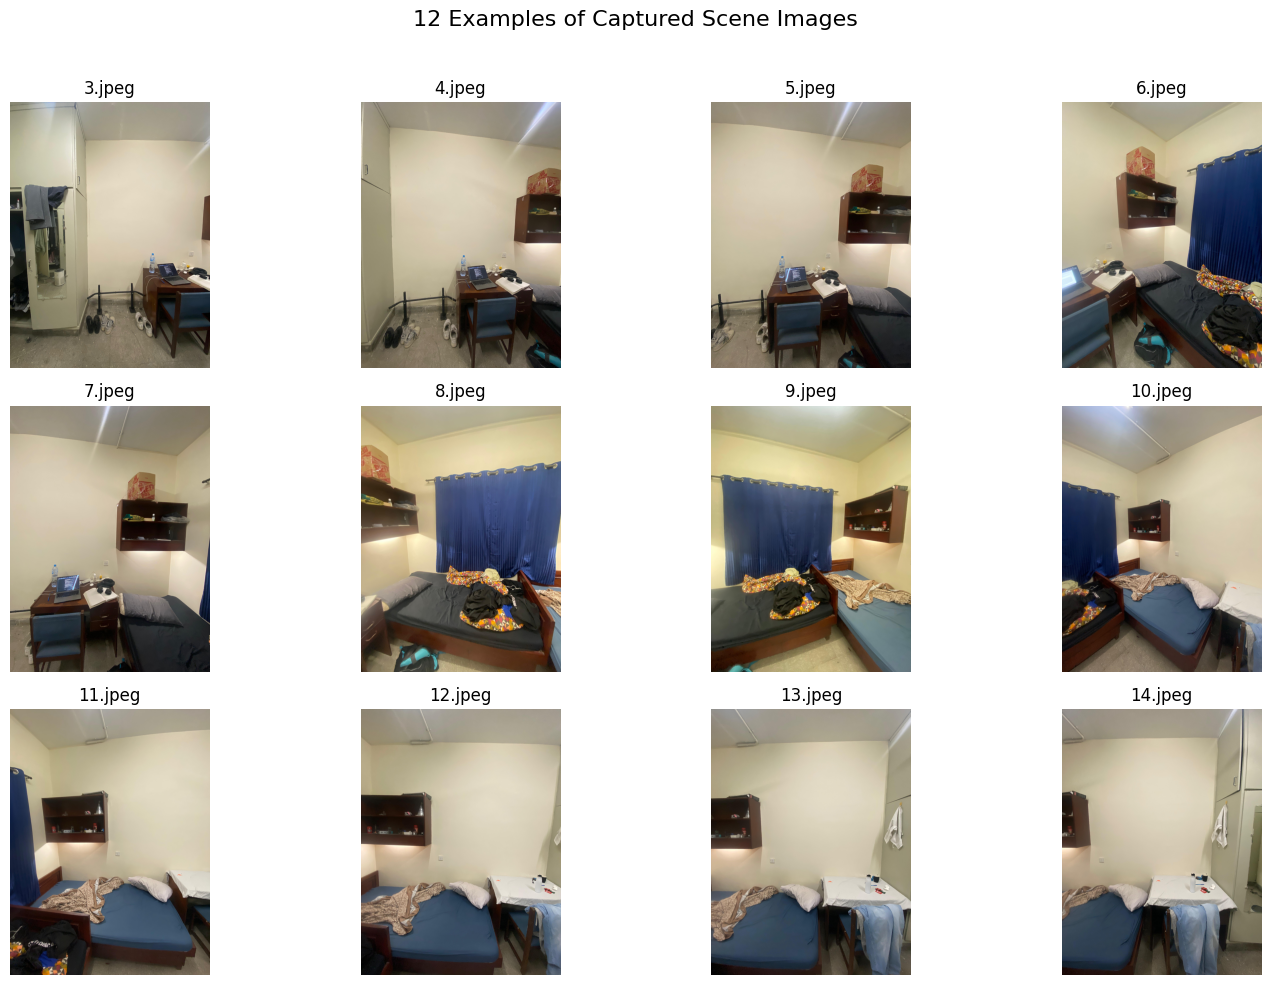

In [3]:
images_to_display = {k: all_images[k] for k in list(all_images.keys())[2:14]} 

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i, (name, img) in enumerate(images_to_display.items()):
    axes[i].imshow(img)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.suptitle("12 Examples of Captured Scene Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

Evaluating feature matches across the first 5 images: ['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg']
Found 215 high-quality matches between 1.jpeg and 2.jpeg.


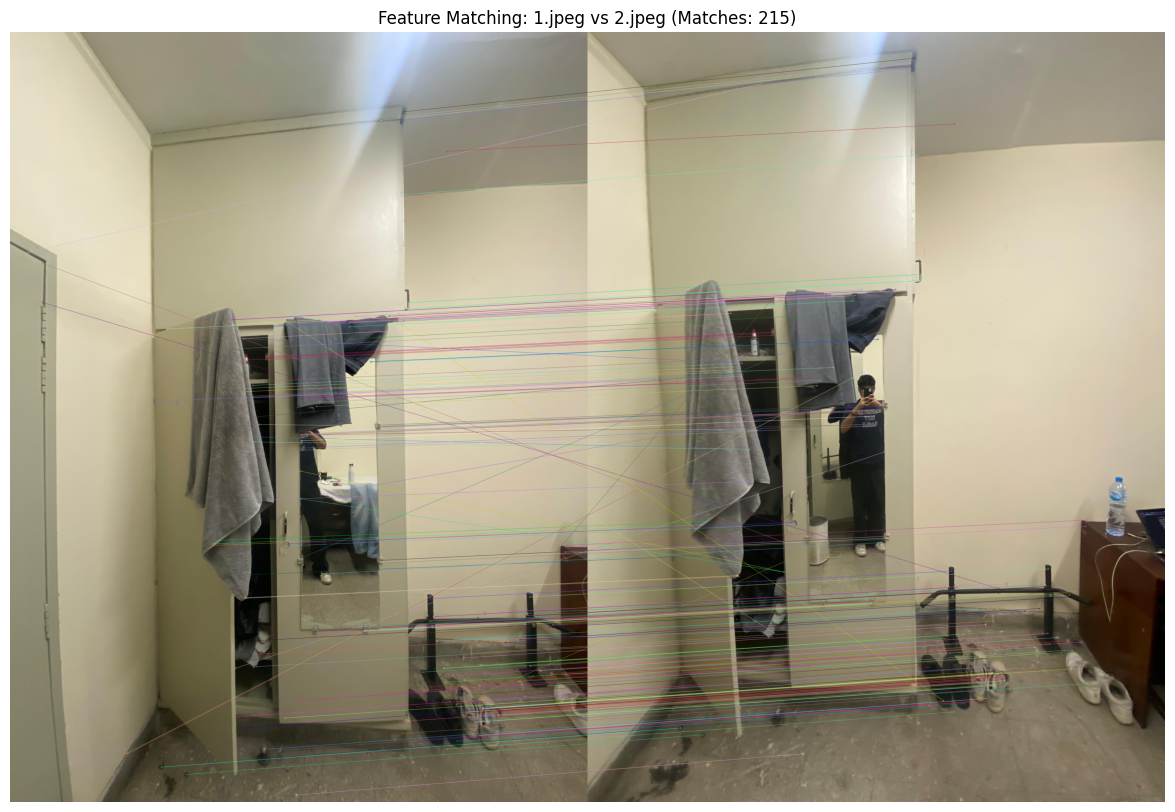

Found 127 high-quality matches between 2.jpeg and 3.jpeg.


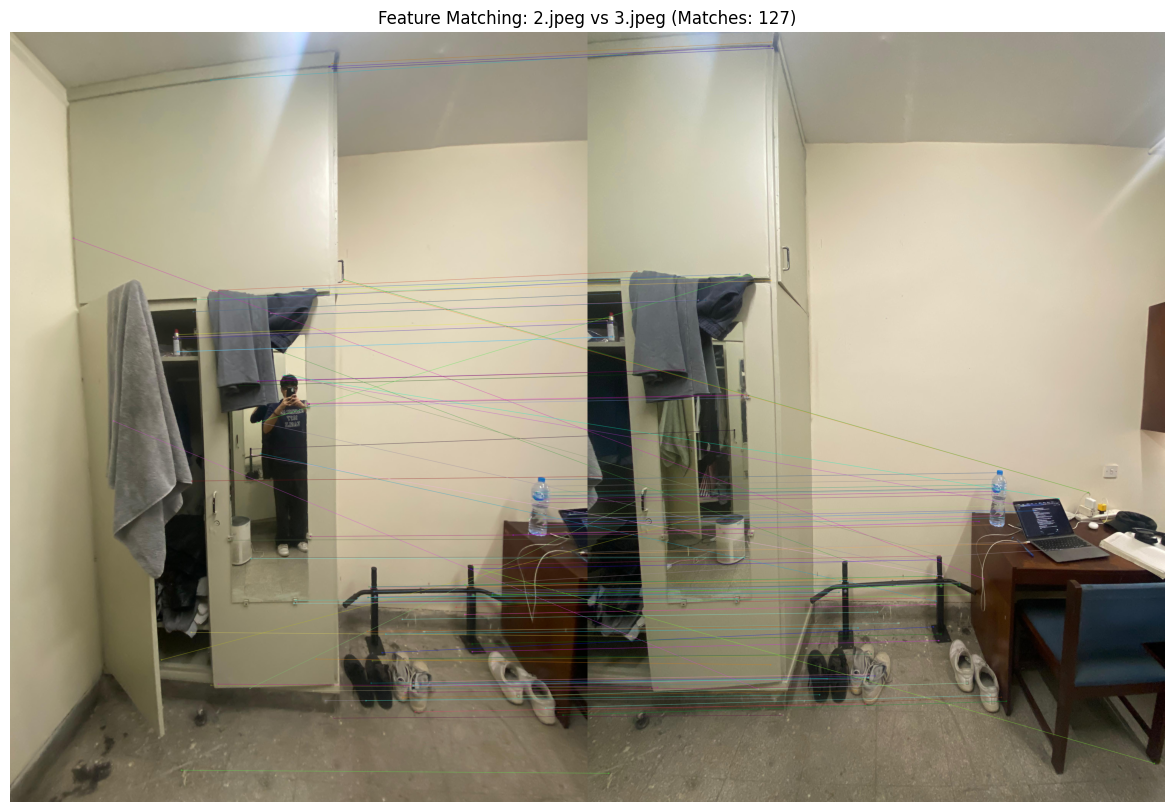

Found 210 high-quality matches between 3.jpeg and 4.jpeg.


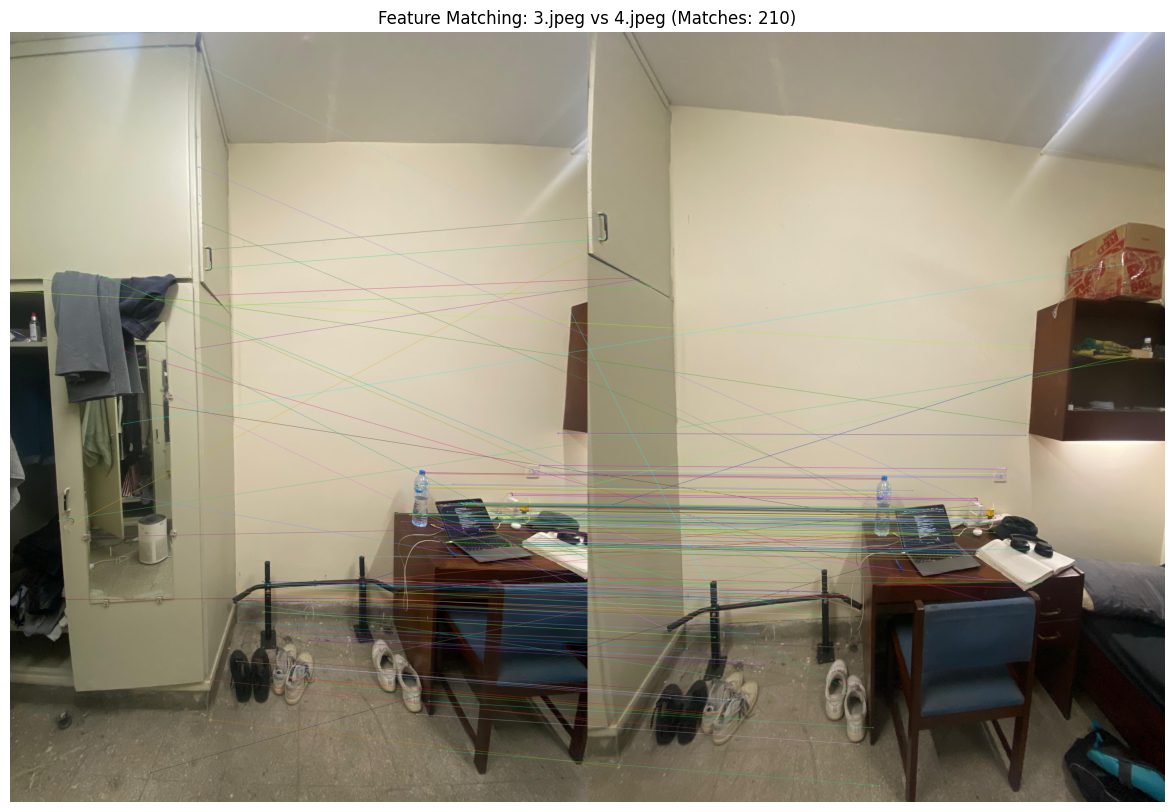

Found 228 high-quality matches between 4.jpeg and 5.jpeg.


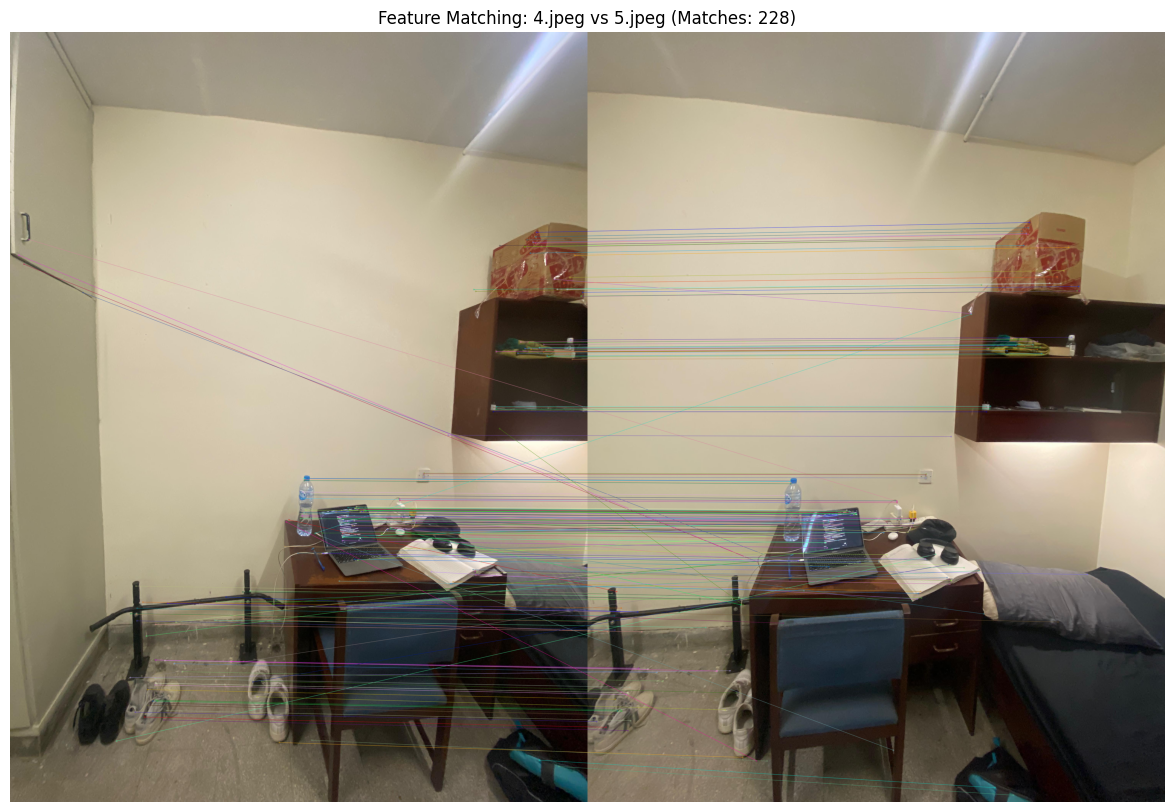

In [4]:
def find_and_match_features(img1, img2, ratio_thresh=0.7,image_a_name="img1", image_b_name="img2",show=True):
    sift = cv2.SIFT_create()
    #cpmvert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    #kps and descriptors
    keypoints1, des1 = sift.detectAndCompute(gray1, None)
    keypoints2, des2 = sift.detectAndCompute(gray2, None)

    #if no descriptors
    if des1 is None or des2 is None:
        return keypoints1, keypoints2, []

    #bfmatcher and knn
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    raw_matches = bf.knnMatch(des1, des2, k=2)

    #lowes test
    good_matches = []
    for m, n in raw_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)


    return keypoints1, keypoints2, good_matches


MATCH_IMAGE_COUNT = 5
image_subset = list(all_images.keys())[:MATCH_IMAGE_COUNT]
print(f"Evaluating feature matches across the first {len(image_subset)} images: {image_subset}")

match_results = []
for idx in range(len(image_subset) - 1):
    image_a_name = image_subset[idx]
    image_b_name = image_subset[idx + 1]

    img_a = all_images[image_a_name]
    img_b = all_images[image_b_name]

    kp_a, kp_b, matches = find_and_match_features(img_a, img_b)
    match_results.append((image_a_name, image_b_name, kp_a, kp_b, matches))

    print(f"Found {len(matches)} high-quality matches between {image_a_name} and {image_b_name}.")

    img_a_bgr = cv2.cvtColor(img_a, cv2.COLOR_RGB2BGR)
    img_b_bgr = cv2.cvtColor(img_b, cv2.COLOR_RGB2BGR)

    img_matches = cv2.drawMatches(
        img_a_bgr,
        kp_a,
        img_b_bgr,
        kp_b,
        matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches_rgb)
    plt.title(
        f"Feature Matching: {image_a_name} vs {image_b_name} "
        f"(Matches: {len(matches)})"
    )
    plt.axis('off')
    plt.show()

# Week 2: Two-View Reconstruction

Here we have implemented the full two-view reconstruction pipeline. This includes:

- Estimating the essential matrix from matched feature points using our previously defined functions
- Recovering the the relative camera pose (R, t)
- Triangulate 3D points to obtain a sparse point cloud
- Save the point cloud to a `.ply` file
- Visualize the 3D point cloud (3D scatter) and a 2D projection


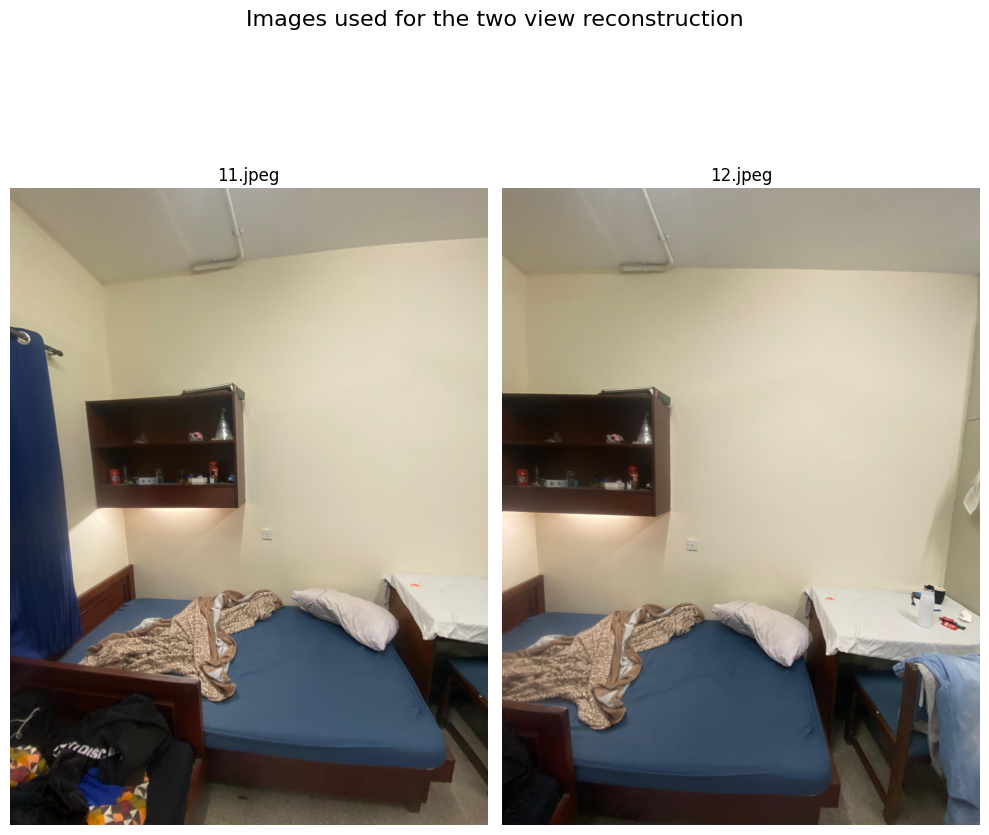

In [5]:
first_img = IMAGE_FILENAMES[10] #chose the first and second images
second_img = IMAGE_FILENAMES[11]

img1 = all_images[first_img]
img2 = all_images[second_img]

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img1)
axes[0].axis("off")
axes[0].set_title(first_img)

axes[1].imshow(img2)
axes[1].axis("off")
axes[1].set_title(second_img)

plt.suptitle("Images used for the two view reconstruction", fontsize = 16)
plt.tight_layout()
plt.show()

In [6]:
def build_intrinsics_from_image(img):
    #build intrinsics matrix K from image size
    #according to manual: principal point at img centre
    #f_x=f_y=img_width
    height, width = img.shape[:2]
    f = float(width)
    cx = width / 2.0
    cy = height / 2.0
    K = np.array([[f,   0, cx],
                  [0,   f, cy],
                  [0,   0,  1]], dtype=np.float64)
    return K

K = build_intrinsics_from_image(img1)
print("K matrix: \n", K)


K matrix: 
 [[3.024e+03 0.000e+00 1.512e+03]
 [0.000e+00 3.024e+03 2.016e+03]
 [0.000e+00 0.000e+00 1.000e+00]]


In [7]:
# feature matching, essential matrix estimation and pose recovery
keypoints1, keypoints2, matches = find_and_match_features(img1, img2, ratio_thresh=0.7)
print("Good matches found:", len(matches))

#some matchers return nested lists -> flatten if needed
if len(matches) > 0 and isinstance(matches[0], list):
    matches = [m for sub in matches for m in sub]

# convert to properly shaped (N,2) float32 arrays
coords1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
coords2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

print("coords1 shape:", coords1.shape)
print("coords2 shape:", coords2.shape)

#essential matrix
E, mask_E = cv2.findEssentialMat(
    coords1,
    coords2,
    K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=0.6
)
print("Essential mat E:\n", E)

# only inlier matches
inlier_mask = mask_E.ravel().astype(bool)
coords1_inliers = coords1[inlier_mask]
coords2_inliers = coords2[inlier_mask]
print("Inliers after E:", coords1_inliers.shape[0])

#pose recovery
_, R, t, mask_pose = cv2.recoverPose(E, coords1_inliers, coords2_inliers, K)
print("Recovered rotation R:\n", R)
print("Recovered translation t:\n", t.ravel())

# Final inliers after pose refinement
pose_inliers = mask_pose.ravel().astype(bool)
coords1_final = coords1_inliers[pose_inliers]
coords2_final = coords2_inliers[pose_inliers]
print("Inliers after pose recovery:", coords1_final.shape[0])


Good matches found: 660
coords1 shape: (660, 2)
coords2 shape: (660, 2)
Essential mat E:
 [[-0.00622633  0.54308268 -0.11486152]
 [-0.49402352 -0.00811616  0.48854038]
 [ 0.12517956 -0.43898846 -0.0255277 ]]
Inliers after E: 328
Recovered rotation R:
 [[ 0.99514537 -0.00931236 -0.09797439]
 [ 0.01220284  0.99950653  0.02894468]
 [ 0.0976565  -0.02999974  0.99476792]]
Recovered translation t:
 [-0.61940175 -0.18548957 -0.7628467 ]
Inliers after pose recovery: 328


In [8]:
#triangulating and applying cheirality check

def triangulate_points(K, R, t, coords1, coords2):
    P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))]) #P1 is projection for cam 1 [I|0]
    P2 = K @ np.hstack([R, t]) # camera 2 [R | t]

    coords1_h = coords1.T  
    coords2_h = coords2.T  # shape (2, N) b/c of opencv requirements

    points4D_h = cv2.triangulatePoints(P1, P2, coords1_h, coords2_h)
    threedimpts = (points4D_h[:3, :] / points4D_h[3, :]).T  # (N, 3)

    return threedimpts

threedimpts_all = triangulate_points(K, R, t, coords1_final, coords2_final)

#cheirality check too keep pts in front of both of the cameras
def filter_points_by_cheirality(threedimpts, R, t):
    pts = threedimpts
    z1 = pts[:, 2] #z coordinate of cam 1

    pts_cam2 = (R @ pts.T + t).T #transform points into cam 2 coordinates
    z2 = pts_cam2[:, 2] #cam 2 z coord

    mask = (z1 > 0) & (z2 > 0)
    return pts[mask]

threedimpts = filter_points_by_cheirality(threedimpts_all, R, t)
print("final triangulated points:", threedimpts.shape[0])


final triangulated points: 328


In [9]:
#save point cloud to ply

def save_point_cloud_ply(points, filename, colors=None):
    """Save Nx3 point cloud to a simple ASCII PLY file."""
    points = np.asarray(points, dtype=np.float32)
    n_points = points.shape[0]

    if colors is None:
        # Default: all points white
        colors = np.full((n_points, 3), 255, dtype=np.uint8)
    else:
        colors = np.asarray(colors, dtype=np.uint8)
        if colors.shape[0] != n_points:
            raise ValueError("colors must have same length as points")

    with open(filename, "w") as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {n_points}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for p, c in zip(points, colors):
            f.write(f"{p[0]} {p[1]} {p[2]} {int(c[0])} {int(c[1])} {int(c[2])}\n")


ply_filename = "two_view_point_cloud.ply"
save_point_cloud_ply(threedimpts, ply_filename)
print("point cloud saved to", ply_filename)

point cloud saved to two_view_point_cloud.ply


In [10]:
#for the 3d visualizaiton
from mpl_toolkits.mplot3d import Axes3D  

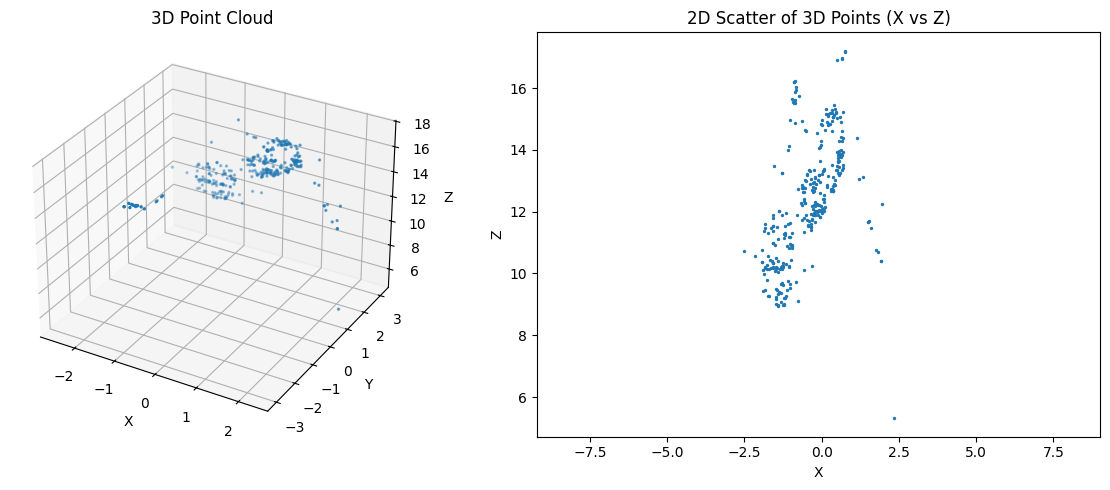

In [11]:
#final 2d and 3d visualization

fig = plt.figure(figsize=(12, 5))

#3d scatter
ax3d = fig.add_subplot(1, 2, 1, projection="3d")
ax3d.scatter(threedimpts[:, 0], threedimpts[:, 1], threedimpts[:, 2], s=2)
ax3d.set_title("3D Point Cloud")
ax3d.set_xlabel("X")
ax3d.set_ylabel("Y")
ax3d.set_zlabel("Z")

# 2D scatter plot (X-Z projection)
ax2d = fig.add_subplot(1, 2, 2)
ax2d.scatter(threedimpts[:, 0], threedimpts[:, 2], s=2)
ax2d.set_title("2D Scatter of 3D Points (X vs Z)")
ax2d.set_xlabel("X")
ax2d.set_ylabel("Z")
ax2d.axis("equal")

plt.tight_layout()
plt.show()

# Week 3: Multi-View SfM & Refinement

## Overview
In this section, we extend the pipeline from a two-view reconstruction to a full incremental Structure-from-Motion (SfM) system capable of reconstructing a scene from a sequence of images.

## Key Tasks:
1.  **Incremental Reconstruction Loop:**
    * Iterate through the image sequence.
    * Match features between the **last processed view** and the **new view**.
    * **Perspective-n-Point (PnP):** Use existing 3D points (from previous triangulations) that correspond to 2D features in the new image to estimate the new camera's pose (`R` and `t`).
    * **Triangulation:** Once the new camera is registered, triangulate *new* matches to expand the 3D point cloud.
2.  **Global Refinement (Bundle Adjustment):**
    * As more frames are added, small errors accumulate (drift).
    * We use non-linear least squares optimization (Bundle Adjustment) to simultaneously refine all camera poses and 3D point positions to minimize the reprojection error.

# Week 3: Multi-View SfM Strategy

Week 3 extends the pipeline beyond the two-view baseline. We register each additional image against the growing 3D map via PnP, triangulate fresh correspondences to expand the structure, and finally refine all poses and 3D points with bundle adjustment so drift is minimized before generating the deliverable point clouds.

In [12]:
# Week 3 configuration: select a valid image sequence and precompute SIFT features
MAX_SEQUENCE_VIEWS = 10

if 'first_img' in globals() and first_img in IMAGE_FILENAMES:
    start_idx = IMAGE_FILENAMES.index(first_img)
else:
    start_idx = 0

candidate_sequence = IMAGE_FILENAMES[start_idx:start_idx + MAX_SEQUENCE_VIEWS + 2]
week3_sequence = [name for name in candidate_sequence if name in all_images]

if len(week3_sequence) < 3:
    fallback_count = min(len(all_images), max(3, MAX_SEQUENCE_VIEWS))
    week3_sequence = [name for name in IMAGE_FILENAMES if name in all_images][:fallback_count]

print(f"Week 3 image sequence ({len(week3_sequence)} views): {week3_sequence}")

sift_detector = cv2.SIFT_create()
keypoints_per_image = []
descriptors_per_image = []

for name in week3_sequence:
    image = all_images[name]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kps, desc = sift_detector.detectAndCompute(gray, None)
    if desc is None:
        desc = np.zeros((0, 128), dtype=np.float32)
    else:
        desc = desc.astype(np.float32)
    keypoints_per_image.append(kps)
    descriptors_per_image.append(desc)
    print(f"{name}: {len(kps)} keypoints")

sequence_index = {name: idx for idx, name in enumerate(week3_sequence)}

Week 3 image sequence (12 views): ['11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg', '15.jpeg', '16.jpeg', '17.jpeg', '18.jpeg', '19.jpeg', '20.jpeg', '21.jpeg', '22.jpeg']
11.jpeg: 5103 keypoints
12.jpeg: 4055 keypoints
13.jpeg: 2419 keypoints
14.jpeg: 2112 keypoints
15.jpeg: 2253 keypoints
16.jpeg: 4196 keypoints
17.jpeg: 3873 keypoints
18.jpeg: 2684 keypoints
19.jpeg: 2572 keypoints
20.jpeg: 1144 keypoints
21.jpeg: 793 keypoints
22.jpeg: 981 keypoints


In [13]:
def match_descriptor_sets(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None or len(desc1) == 0 or len(desc2) == 0:
        return []
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    raw_matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in raw_matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

def projection_matrix(K, R, t):
    return K @ np.hstack([R, t])

def triangulate_between_cameras(K, R1, t1, R2, t2, pts1, pts2):
    if len(pts1) == 0:
        return np.zeros((0, 3), dtype=np.float64)
    P1 = projection_matrix(K, R1, t1)
    P2 = projection_matrix(K, R2, t2)
    pts1_h = np.asarray(pts1, dtype=np.float64).T
    pts2_h = np.asarray(pts2, dtype=np.float64).T
    points4d = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
    points3d = (points4d[:3] / points4d[3]).T
    return points3d

def cheirality_mask(points3d, R, t):
    if points3d.size == 0:
        return np.zeros((0,), dtype=bool)
    pts_cam = (R @ points3d.T + t).T
    return pts_cam[:, 2] > 0

def joint_cheirality(points3d, R1, t1, R2, t2):
    mask1 = cheirality_mask(points3d, R1, t1)
    mask2 = cheirality_mask(points3d, R2, t2)
    finite_mask = np.isfinite(points3d).all(axis=1)
    depth_mask = (np.abs(points3d) < 1e5).all(axis=1)
    return mask1 & mask2 & finite_mask & depth_mask

def sample_keypoint_color(image, point):
    h, w = image.shape[:2]
    x, y = point
    xi = int(np.clip(round(x), 0, w - 1))
    yi = int(np.clip(round(y), 0, h - 1))
    return image[yi, xi]

In [14]:
# Incremental SfM: bootstrap with two views, then register/triangulate the rest
week3_intrinsics = build_intrinsics_from_image(all_images[week3_sequence[0]])
print("Intrinsics used for Week 3 sequence:")
print(week3_intrinsics)

map_points = []
map_descriptors = []
map_colors = []
kp_to_3d = [dict() for _ in week3_sequence]
camera_poses = {0: (np.eye(3), np.zeros((3, 1)))}

def map_descriptor_matrix():
    if len(map_descriptors) == 0:
        return np.zeros((0, 128), dtype=np.float32)
    return np.vstack(map_descriptors)

def create_map_point(point, desc_a, desc_b, obs_dict, color):
    descriptor = ((desc_a + desc_b) / 2.0).astype(np.float32)
    map_points.append({"point": point.astype(np.float64), "observations": dict(obs_dict)})
    map_descriptors.append(descriptor)
    map_colors.append(color.astype(np.uint8))
    idx = len(map_points) - 1
    for cam_idx, kp_idx in obs_dict.items():
        kp_to_3d[cam_idx][kp_idx] = idx
    return idx

bootstrap_matches = match_descriptor_sets(descriptors_per_image[0], descriptors_per_image[1], ratio=0.7)
if len(bootstrap_matches) < 20:
    raise RuntimeError("Insufficient matches to bootstrap the Week 3 reconstruction.")

pts_a = np.float32([keypoints_per_image[0][m.queryIdx].pt for m in bootstrap_matches])
pts_b = np.float32([keypoints_per_image[1][m.trainIdx].pt for m in bootstrap_matches])

E, mask_E = cv2.findEssentialMat(
    pts_a,
    pts_b,
    week3_intrinsics,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0,
)

if E is None or mask_E is None:
    raise RuntimeError("Essential matrix estimation failed for Week 3 bootstrap.")

mask_E = mask_E.ravel().astype(bool)
pts_a = pts_a[mask_E]
pts_b = pts_b[mask_E]
bootstrap_matches = [m for m, keep in zip(bootstrap_matches, mask_E) if keep]

_, R_init, t_init, pose_mask = cv2.recoverPose(E, pts_a, pts_b, week3_intrinsics)
pose_mask = pose_mask.ravel().astype(bool)
pts_a = pts_a[pose_mask]
pts_b = pts_b[pose_mask]
bootstrap_matches = [m for m, keep in zip(bootstrap_matches, pose_mask) if keep]

points3d = triangulate_between_cameras(
    week3_intrinsics,
    np.eye(3),
    np.zeros((3, 1)),
    R_init,
    t_init,
    pts_a,
    pts_b,
)
valid_mask = joint_cheirality(points3d, np.eye(3), np.zeros((3, 1)), R_init, t_init)
points3d = points3d[valid_mask]
bootstrap_matches = [m for m, keep in zip(bootstrap_matches, valid_mask) if keep]

for match, point in zip(bootstrap_matches, points3d):
    desc_prev = descriptors_per_image[0][match.queryIdx]
    desc_next = descriptors_per_image[1][match.trainIdx]
    color_prev = sample_keypoint_color(all_images[week3_sequence[0]], keypoints_per_image[0][match.queryIdx].pt)
    color_next = sample_keypoint_color(all_images[week3_sequence[1]], keypoints_per_image[1][match.trainIdx].pt)
    blended_color = ((color_prev.astype(np.float32) + color_next.astype(np.float32)) / 2.0).astype(np.uint8)
    create_map_point(point, desc_prev, desc_next, {0: match.queryIdx, 1: match.trainIdx}, blended_color)

camera_poses[1] = (R_init, t_init)
last_registered_idx = 1
print(f"Bootstrap initialized with {len(map_points)} reliable points.")

for current_idx in range(2, len(week3_sequence)):
    desc_new = descriptors_per_image[current_idx]
    kps_new = keypoints_per_image[current_idx]
    map_desc = map_descriptor_matrix()
    if len(map_desc) < 6 or len(desc_new) == 0:
        print(f"Skipping view {current_idx} ({week3_sequence[current_idx]}) - insufficient descriptors.")
        continue

    matches_map_new = match_descriptor_sets(map_desc, desc_new, ratio=0.75)
    if len(matches_map_new) < 25:
        print(f"Skipping view {current_idx} ({week3_sequence[current_idx]}) - only {len(matches_map_new)} 2D-3D matches.")
        continue

    object_points = np.array([map_points[m.queryIdx]['point'] for m in matches_map_new], dtype=np.float32)
    image_points = np.array([kps_new[m.trainIdx].pt for m in matches_map_new], dtype=np.float32)
    map_refs = [(m.queryIdx, m.trainIdx) for m in matches_map_new]

    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        object_points,
        image_points,
        week3_intrinsics,
        None,
        iterationsCount=200,
        reprojectionError=3.5,
        confidence=0.999,
        flags=cv2.SOLVEPNP_ITERATIVE,
    )
    if not success:
        print(f"PnP failed for view {current_idx} ({week3_sequence[current_idx]}).")
        continue

    prev_idx = last_registered_idx
    last_registered_idx = current_idx

    inlier_indices = inliers.ravel().tolist() if inliers is not None else list(range(len(map_refs)))
    R_new, _ = cv2.Rodrigues(rvec)
    t_new = tvec.reshape(3, 1)
    camera_poses[current_idx] = (R_new, t_new)

    for idx_inlier in inlier_indices:
        map_idx, kp_idx = map_refs[idx_inlier]
        map_points[map_idx]['observations'][current_idx] = kp_idx
        kp_to_3d[current_idx][kp_idx] = map_idx

    print(f"Registered view {current_idx} ({week3_sequence[current_idx]}) with {len(inlier_indices)} inlier correspondences.")

    prev_kps = keypoints_per_image[prev_idx]
    prev_desc = descriptors_per_image[prev_idx]
    matches_prev_curr = match_descriptor_sets(prev_desc, desc_new, ratio=0.7)

    candidate_matches = []
    pts_prev = []
    pts_curr = []
    for m in matches_prev_curr:
        if m.queryIdx in kp_to_3d[prev_idx]:
            continue
        if m.trainIdx in kp_to_3d[current_idx]:
            continue
        candidate_matches.append(m)
        pts_prev.append(prev_kps[m.queryIdx].pt)
        pts_curr.append(kps_new[m.trainIdx].pt)

    if len(candidate_matches) < 8:
        print(f"Skipped triangulation for view {current_idx} - only {len(candidate_matches)} fresh matches.")
        continue

    pts_prev = np.asarray(pts_prev, dtype=np.float32)
    pts_curr = np.asarray(pts_curr, dtype=np.float32)
    R_prev, t_prev = camera_poses[prev_idx]
    points_candidate = triangulate_between_cameras(
        week3_intrinsics,
        R_prev,
        t_prev,
        R_new,
        t_new,
        pts_prev,
        pts_curr,
    )
    valid_mask = joint_cheirality(points_candidate, R_prev, t_prev, R_new, t_new)

    added_points = 0
    for match, point, keep in zip(candidate_matches, points_candidate, valid_mask):
        if not keep:
            continue
        desc_prev = prev_desc[match.queryIdx]
        desc_curr = desc_new[match.trainIdx]
        color_prev = sample_keypoint_color(all_images[week3_sequence[prev_idx]], prev_kps[match.queryIdx].pt)
        color_curr = sample_keypoint_color(all_images[week3_sequence[current_idx]], kps_new[match.trainIdx].pt)
        blended_color = ((color_prev.astype(np.float32) + color_curr.astype(np.float32)) / 2.0).astype(np.uint8)
        create_map_point(point, desc_prev, desc_curr, {prev_idx: match.queryIdx, current_idx: match.trainIdx}, blended_color)
        added_points += 1

    print(f"Triangulated {added_points} new points between views {prev_idx} and {current_idx}.")

print(f"Registered {len(camera_poses)} / {len(week3_sequence)} cameras.")
print(f"Current map size: {len(map_points)} points.")

Intrinsics used for Week 3 sequence:
[[3.024e+03 0.000e+00 1.512e+03]
 [0.000e+00 3.024e+03 2.016e+03]
 [0.000e+00 0.000e+00 1.000e+00]]
Bootstrap initialized with 428 reliable points.
Registered view 2 (13.jpeg) with 93 inlier correspondences.
Triangulated 363 new points between views 1 and 2.
Registered view 3 (14.jpeg) with 36 inlier correspondences.
Triangulated 138 new points between views 2 and 3.
Registered view 4 (15.jpeg) with 19 inlier correspondences.
Triangulated 108 new points between views 3 and 4.
Registered view 5 (16.jpeg) with 10 inlier correspondences.
Triangulated 111 new points between views 4 and 5.
Registered view 6 (17.jpeg) with 7 inlier correspondences.
Triangulated 156 new points between views 5 and 6.
Registered view 7 (18.jpeg) with 8 inlier correspondences.
Triangulated 153 new points between views 6 and 7.
Registered view 8 (19.jpeg) with 6 inlier correspondences.
Triangulated 147 new points between views 7 and 8.
PnP failed for view 9 (20.jpeg).
PnP fail

In [15]:
raw_points = np.array([entry['point'] for entry in map_points], dtype=np.float32)
raw_colors = np.array(map_colors, dtype=np.uint8) if len(map_colors) else None

if len(raw_points) == 0:
    print("No points reconstructed for Week 3 yet.")
else:
    raw_ply = "multiview_point_cloud_raw.ply"
    save_point_cloud_ply(raw_points, raw_ply, raw_colors)
    print(f"Saved raw multi-view point cloud with {len(raw_points)} points to {raw_ply}.")

Saved raw multi-view point cloud with 1604 points to multiview_point_cloud_raw.ply.


In [16]:
try:
    from scipy.optimize import least_squares
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False

def reprojection_rmse(camera_pose_dict, structure_points):
    errors = []
    for point_idx, point in enumerate(structure_points):
        observations = map_points[point_idx]['observations']
        for cam_idx, kp_idx in observations.items():
            if cam_idx not in camera_pose_dict:
                continue
            R, t = camera_pose_dict[cam_idx]
            kp = keypoints_per_image[cam_idx][kp_idx]
            pt_cam = R @ point.reshape(3, 1) + t
            z = pt_cam[2, 0]
            if z <= 1e-6:
                continue
            proj = week3_intrinsics @ pt_cam
            proj = proj[:2] / proj[2]
            errors.append(np.linalg.norm(proj - kp.pt))
    return float(np.mean(errors)) if errors else 0.0

if not SCIPY_AVAILABLE:
    print("SciPy is not available - skipping bundle adjustment.")
else:
    registered_camera_indices = sorted(camera_poses.keys())
    if len(registered_camera_indices) < 2 or len(map_points) < 20:
        print("Bundle adjustment skipped (need at least 2 cameras and 20 points).")
    else:
        base_cam_idx = registered_camera_indices[0]
        cam_idx_to_order = {cam_idx: order for order, cam_idx in enumerate(registered_camera_indices)}
        cam_params = []
        for cam_idx in registered_camera_indices:
            R, t = camera_poses[cam_idx]
            rvec, _ = cv2.Rodrigues(R)
            cam_params.append(np.hstack([rvec.ravel(), t.ravel()]))
        cam_params = np.asarray(cam_params, dtype=np.float64)
        fixed_cam_param = cam_params[0]
        cam_params_opt_init = cam_params[1:]
        n_cams_opt = cam_params_opt_init.shape[0]
        if n_cams_opt == 0:
            print("Only one registered camera - bundle adjustment is not required.")
        else:
            obs_cam_indices = []
            obs_point_indices = []
            obs_measurements = []
            for point_idx, point_entry in enumerate(map_points):
                for cam_idx, kp_idx in point_entry['observations'].items():
                    if cam_idx not in cam_idx_to_order:
                        continue
                    kp = keypoints_per_image[cam_idx][kp_idx]
                    obs_cam_indices.append(cam_idx)
                    obs_point_indices.append(point_idx)
                    obs_measurements.append(kp.pt)
            if len(obs_cam_indices) < 40:
                print("Bundle adjustment skipped (not enough total observations).")
            else:
                obs_cam_indices = np.asarray(obs_cam_indices, dtype=np.int32)
                obs_point_indices = np.asarray(obs_point_indices, dtype=np.int32)
                obs_measurements = np.asarray(obs_measurements, dtype=np.float64)
                points3d_init = np.asarray([entry['point'] for entry in map_points], dtype=np.float64)

                def project_point(cam_param, point):
                    rvec = cam_param[:3]
                    tvec = cam_param[3:].reshape(3, 1)
                    R, _ = cv2.Rodrigues(rvec)
                    pt_cam = R @ point.reshape(3, 1) + tvec
                    z = pt_cam[2, 0]
                    if z <= 1e-6:
                        z = 1e-6
                    proj = week3_intrinsics @ pt_cam
                    proj = proj[:2] / proj[2]
                    return proj.ravel()

                def split_variables(vector):
                    cam_vars = vector[: n_cams_opt * 6].reshape((n_cams_opt, 6))
                    pts = vector[n_cams_opt * 6 :].reshape((-1, 3))
                    return cam_vars, pts

                cam_idx_to_opt = {cam_idx: order - 1 for order, cam_idx in enumerate(registered_camera_indices) if order > 0}

                def residuals(vector):
                    cam_vars, pts = split_variables(vector)
                    residual = np.zeros(obs_cam_indices.shape[0] * 2, dtype=np.float64)
                    for idx, (cam_idx, pt_idx) in enumerate(zip(obs_cam_indices, obs_point_indices)):
                        if cam_idx == base_cam_idx:
                            cam_param = fixed_cam_param
                        else:
                            cam_param = cam_vars[cam_idx_to_opt[cam_idx]]
                        proj = project_point(cam_param, pts[pt_idx])
                        residual[idx * 2 : idx * 2 + 2] = proj - obs_measurements[idx]
                    return residual

                x0 = np.hstack([cam_params_opt_init.ravel(), points3d_init.ravel()])
                pre_ba_error = reprojection_rmse(camera_poses, points3d_init)
                ba_result = least_squares(
                    residuals,
                    x0,
                    method='trf',
                    loss='huber',
                    max_nfev=50,
                    ftol=1e-4,
                    xtol=1e-4,
                    gtol=1e-4,
                )

                cam_vars_opt, refined_points = split_variables(ba_result.x)
                refined_cam_params = [fixed_cam_param] + [row for row in cam_vars_opt]
                for order, cam_idx in enumerate(registered_camera_indices):
                    params = refined_cam_params[order]
                    R_refined, _ = cv2.Rodrigues(params[:3])
                    t_refined = params[3:].reshape(3, 1)
                    camera_poses[cam_idx] = (R_refined, t_refined)

                for idx, point in enumerate(refined_points):
                    map_points[idx]['point'] = point

                post_ba_error = reprojection_rmse(camera_poses, np.asarray([entry['point'] for entry in map_points], dtype=np.float64))
                print(f"Bundle adjustment success: {ba_result.success}, iterations: {ba_result.nfev}")
                print(f"Reprojection RMSE improved from {pre_ba_error:.3f}px to {post_ba_error:.3f}px.")

Bundle adjustment success: True, iterations: 9
Reprojection RMSE improved from 1965.369px to 1930.563px.


Saved refined point cloud with 1604 points to multiview_point_cloud_refined.ply.


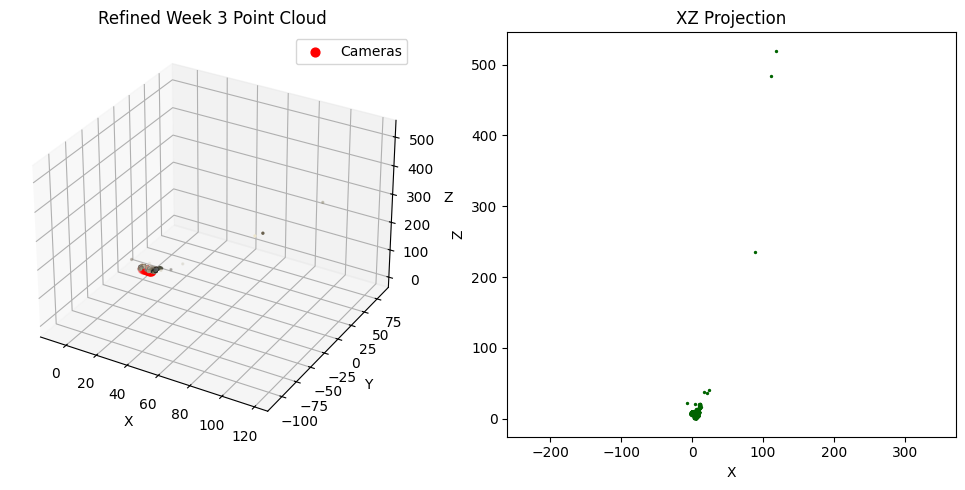

In [17]:
refined_points = np.array([entry['point'] for entry in map_points], dtype=np.float32)
refined_colors = np.array(map_colors, dtype=np.uint8) if len(map_colors) else None

if len(refined_points) == 0:
    print("No refined points available for visualization.")
else:
    refined_ply = "multiview_point_cloud_refined.ply"
    save_point_cloud_ply(refined_points, refined_ply, refined_colors)
    print(f"Saved refined point cloud with {len(refined_points)} points to {refined_ply}.")

    sample_count = min(4000, len(refined_points))
    sample_idx = np.linspace(0, len(refined_points) - 1, sample_count, dtype=int) if len(refined_points) > 1 else np.array([0])
    sampled_points = refined_points[sample_idx]
    color_values = (refined_colors[sample_idx] / 255.0) if refined_colors is not None else 'steelblue'

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], s=2, c=color_values)
    ax.set_title('Refined Week 3 Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    camera_centers = []
    for cam_idx in sorted(camera_poses.keys()):
        R, t = camera_poses[cam_idx]
        cam_center = (-R.T @ t).ravel()
        camera_centers.append(cam_center)
    camera_centers = np.asarray(camera_centers)
    if camera_centers.size > 0:
        ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='red', s=40, label='Cameras')
        ax.legend()

    ax2 = fig.add_subplot(122)
    ax2.scatter(sampled_points[:, 0], sampled_points[:, 2], s=2, c='darkgreen')
    ax2.set_title('XZ Projection')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.axis('equal')

    plt.tight_layout()
    plt.show()